In [17]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  
from GPyOpt.methods import BayesianOptimization

Neural Network Model for Hyper Parameter Tuning

In [18]:
def benchmark(X, Y):
    return -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)


In [19]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [20]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, y, a, b: 0.1 * (a - 4) * x + 0.05 * (b + 3) * y**2 + 0.03 * x * y + r.normal(0, sim_stdev)

In [21]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 5, pretrain_n)
Y = np.random.uniform(-5, 5, pretrain_n)

# Calculate the outputs using Himmelblau's Function
output1 = benchmark(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset of Physical Experiments
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [22]:
sim_eval = lambda x, y, a, b: benchmark(x, y) + sim_err(x, y, a, b)

In [23]:
df

,x,y,z
0,-0.829780,-0.808055,-175.141124
1,2.203245,1.852195,-20.326731
2,-4.998856,-2.955478,-132.403402
3,-1.976674,3.781174,-39.397506
4,-3.532441,-4.726124,-149.789289
5,-4.076614,1.704675,-120.336105
6,-3.137398,-0.826952,-93.320859
7,-1.544393,0.586898,-131.648403
8,-1.032325,-3.596131,-207.066951
9,0.388167,-3.018985,-198.619945


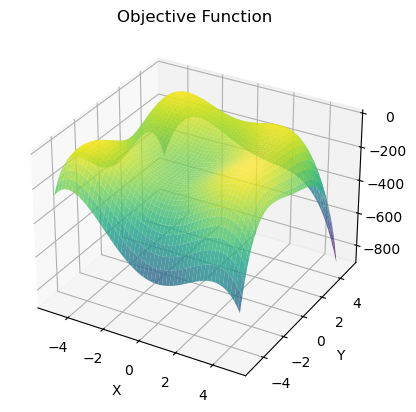

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = benchmark(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Objective Function')

# Show the plot
plt.show()

In [25]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [26]:
# Define the known global maxima for the Himmelblau's function
global_maxima_points = [
    {"X": 3, "Y":  2, "Z": benchmark(0,  0)},
    {"X": -2.805, "Y":  3.131, "Z": benchmark(0,  0)},
    {"X": -3.779, "Y":  -3.283, "Z": benchmark(0,  0)},
    {"X": 3.584, "Y":  -1.848, "Z": benchmark(0,  0)},
]

# Create a DataFrame for the global maxima
global_maxima_df = pd.DataFrame(global_maxima_points)
global_maxima_df

,X,Y,Z
0,3.000,2.000,-170
1,-2.805,3.131,-170
2,-3.779,-3.283,-170
3,3.584,-1.848,-170


In [27]:
def perform_iteration(df):

    def sim_all(x):
        df["a"] = x[0,0]
        df["b"] = x[0,1]
        df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
        df["diff"] = df["z"] - df["sim_z"]
        return (df["diff"]**2).sum()

    bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (-10,10)},
            {'name': 'b', 'type': 'continuous', 'domain': (-10,10)}]

    # Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
    bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
    bo.run_optimization(max_iter=max_bo_iter)
    df["a"] = bo.x_opt[0]
    df["b"] = bo.x_opt[1]
    print(bo.x_opt)

    # Create the grid of input values
    x_range = np.linspace(-5, 5, 100)
    y_range = np.linspace(-5, 5, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[1])

    # Create the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors')

    # Show the plot
    plt.show()

    # Generate 15 points using Latin Hypercube Sampling (LHS)
    n_samples = 90
    lhs= qmc.LatinHypercube(d=2, optimization="random-cd")
    lhs_samples = lhs.random(n=n_samples)
    bounds = np.array([[-5, 5], [-5, 5]])  # Bounds for Design Space

    scaled_samples = qmc.scale(lhs_samples, bounds[:, 0], bounds[:, 1])

    selected_points_df = pd.DataFrame(scaled_samples, columns=['x', 'y'])
    selected_points_df['sim_z'] = sim_eval(selected_points_df['x'], selected_points_df['y'], bo.x_opt[0], bo.x_opt[1])

    sim_df = df[["x", "y", "sim_z"]]
    sim_df = pd.concat([sim_df, selected_points_df], axis=0, ignore_index=True)
    
    # # Define the objective function to minimize
    # @use_named_args(hyp_space)
    # def objective(**params):
    #     num_layers = params['num_layers']
    #     num_units = params['num_units']
    #     learning_rate = params['learning_rate']
    #     dropout_rate = params['dropout_rate']
    #     batch_size = params['batch_size']
    #     epochs = params['epochs']

    #     model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
    #     # Define K-fold cross-validation
    #     kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    #     scores = []

    #     # Perform cross-validation
    #     for train_idx, val_idx in kfold.split(df[['x', 'y']]):
    #         X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
    #         y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

    #         # Standardize the features
    #         scaler_x = StandardScaler().fit(X_train)
    #         X_train_scaled = scaler_x.transform(X_train)
    #         X_val_scaled = scaler_x.transform(X_val)

    #         # Train the model
    #         model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

    #         # Evaluate the model
    #         score = model.evaluate(X_val_scaled, y_val, verbose=0)
    #         scores.append(score)
    
    #     return np.mean(scores)

    # # Perform Bayesian optimization
    # result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # # Output best hyperparameters from BayesOpt
    # print("Best hyperparameters:")
    # print("num_layers:", result.x[0])
    # print("num_units:", result.x[1])
    # print("learning_rate:", result.x[2])
    # print("dropout_rate:", result.x[3])
    # print("batch_size:", result.x[4])
    # print("epochs:", result.x[5])

    # # Train the model with the best hyperparameters on the entire dataset
    # best_model = NN_model(
    #     num_layers=result.x[0],
    #     num_units=result.x[1],
    #     learning_rate=result.x[2],
    #     dropout_rate=result.x[3]
    # )
    best_model = NN_model(
        num_layers=9,
        num_units=170,
        learning_rate=0.001,
        dropout_rate=0.0
    )


    # Standardize the Dataset of Simulation Responses
    scaler = StandardScaler().fit(sim_df[['x', 'y']])
    X_scaled = scaler.transform(sim_df[['x', 'y']])

    # Train the best model on the combined standardized dataset
    best_model.fit(X_scaled, sim_df[['sim_z']], epochs=500, batch_size=64, verbose=1)

    # Create a meshgrid and combine into a single array
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]

    # Perform MC Dropout predictions on the entire grid
    xy_grid_scaled = scaler.transform(xy_grid)
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid_scaled)

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Customize the plot
    ax.set_title('Neural Network of Simulated Response with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Output')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()
    
    x_range = [(-5, 5)]
    y_range = [(-5, 5)]
    def p_nn(xy):
        xy = np.array(xy).reshape(1, -1)  # Ensure correct shape (1,2)
        xy_scaled = scaler.transform(xy)
        pred_mean, pred_std = mc_dropout_predictions(best_model, xy_scaled)
        # Check if the point is inside the valid domain
        if (x_range[0][0] <= xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= xy[0, 1] <= y_range[0][1]):
            
            probability = max(pred_mean + 1.96 * pred_std - sim_df["sim_z"].median(), 1e-6)  # Avoid zero
            return probability
        else:
            return 1e-10  # Keep very small but nonzero probability for out-of-bounds case


    def metropolis_step(xy, sig):
        prop_xy = xy + np.random.normal(0, sig, size=xy.shape)  # Generate a candidate

        # Ensure proposed point is inside the valid bounds
        if not (x_range[0][0] <= prop_xy[0, 0] <= x_range[0][1] and 
                y_range[0][0] <= prop_xy[0, 1] <= y_range[0][1]):
            return xy  # Reject out-of-bounds proposals

        u = np.random.uniform(0, 1)
        if u < min(1.0, p_nn(prop_xy) / p_nn(xy)):
            return prop_xy  # Accept move
        else:
            return xy  # Stay at current point


    def mh_sampler(sig, sample_size, burn_in, lag):
        # Start at the point with the largest simulated response
        max_idx = np.argmax(sim_df["sim_z"])
        x_init = sim_df["x"].iloc[max_idx]
        y_init = sim_df["y"].iloc[max_idx]
        xy = np.array([[x_init, y_init]])

        # Burn-in phase
        for i in range(burn_in):
            xy = metropolis_step(xy, sig)

        # Sampling phase
        output = xy
        for i in range(sample_size - 1):
            for j in range(lag):
                xy = metropolis_step(xy, sig)
            output = np.vstack((output, xy))  # Stack valid samples

        return output  # Returns an array of shape (sample_size, 2)

    max_idx = np.argmax(sim_df["sim_z"])
    x_max = sim_df["x"].iloc[max_idx]
    y_max = sim_df["y"].iloc[max_idx]
    max_point = np.array([[x_max, y_max]])

    X_mh = mh_sampler(sig=5, sample_size=pretrain_n - 1, burn_in=50, lag=20)

    X_all = np.vstack([max_point, X_mh])

    physical_test_points = pd.DataFrame(X_all, columns=["x", "y"])

    # Generate predictions for the heatmap
    pred_mean_grid = pred_mean.reshape(x_grid.shape)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = plt.contourf(x_grid, y_grid, pred_mean_grid, cmap='viridis', levels=50)
    plt.colorbar(heatmap, label="Neural Network Response")

    # Overlay sampled points
    plt.scatter(sim_df['x'], sim_df['y'], color='white', edgecolor='black', label='Simulation Sampled Points')
    plt.scatter(physical_test_points['x'], physical_test_points['y'], color='purple', edgecolor='black', label='Next Physical Test Points')

    # Customize the plot
    plt.title("Heatmap of Neural Network Response")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.show()

    # Add validated data points to original data frame
    physical_test_points["z"] = benchmark(physical_test_points['x'], physical_test_points['y']) + ran_err(pretrain_n, 0.05)
    physical_test_points["a"] = bo.x_opt[0]
    physical_test_points["b"] = bo.x_opt[1]
    physical_test_points["sim_z"] = sim_eval(physical_test_points["x"], physical_test_points["y"], physical_test_points["a"], physical_test_points["b"])
    physical_test_points["diff"] = physical_test_points["z"] - physical_test_points["sim_z"]

    # Heatmap of Simulated Points 
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the heatmap for sim_z_grid
    heatmap = ax.contourf(x_grid, y_grid, sim_z_grid, levels=100, cmap='viridis', alpha=0.8)

    # Overlay scatter points for sampling points
    ax.scatter(df["x"], df["y"], color='blue', marker='o', label='Previous Sampled Points')
    ax.scatter(sim_df["x"], sim_df["y"], edgecolor='black', facecolors='none', marker='o', label='Sampled Simulation Points')
    ax.scatter(physical_test_points["x"], physical_test_points["y"], color='purple', marker='o', label='Next Physical Test Points')

    # Overlay scatter points for global maxima
    ax.scatter(global_maxima_df['X'], global_maxima_df['Y'], color='red', marker='o', label='Global Maximum Point')

    # Customize the plot
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('True Function with Simulation Calibrated Errors (Heatmap)')
    ax.legend()

    # Add a color bar
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.set_label('Function Value (Z)')

    # Show the plot
    plt.show()

    # Add points to original dataframe
    df = pd.concat([df, physical_test_points], axis=0, ignore_index=True)

    return df

[ 4.04660397 -3.22581645]


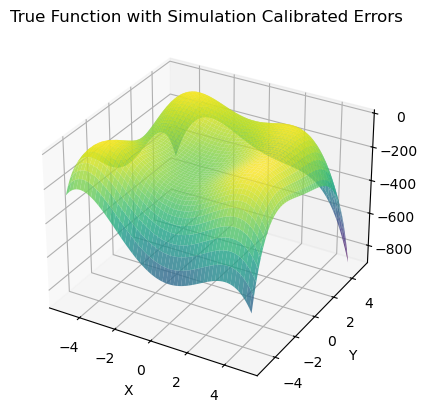

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 26305.6055
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27982.1152 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28065.2852 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30232.7402 
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27414.9434 
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26721.7676 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21037.0645 
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16177.7910 
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10760.1172 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13453.4199 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10527.3115 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9170.4307 
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10825.5361 
Epoch 14/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10196.0156 
Epoch 15/500
2/2 ━━━━━━━━━━━━━━

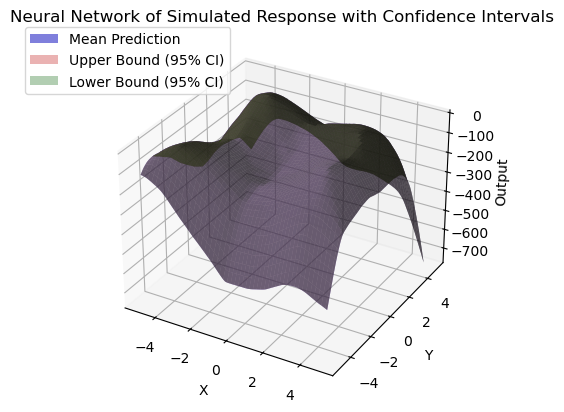

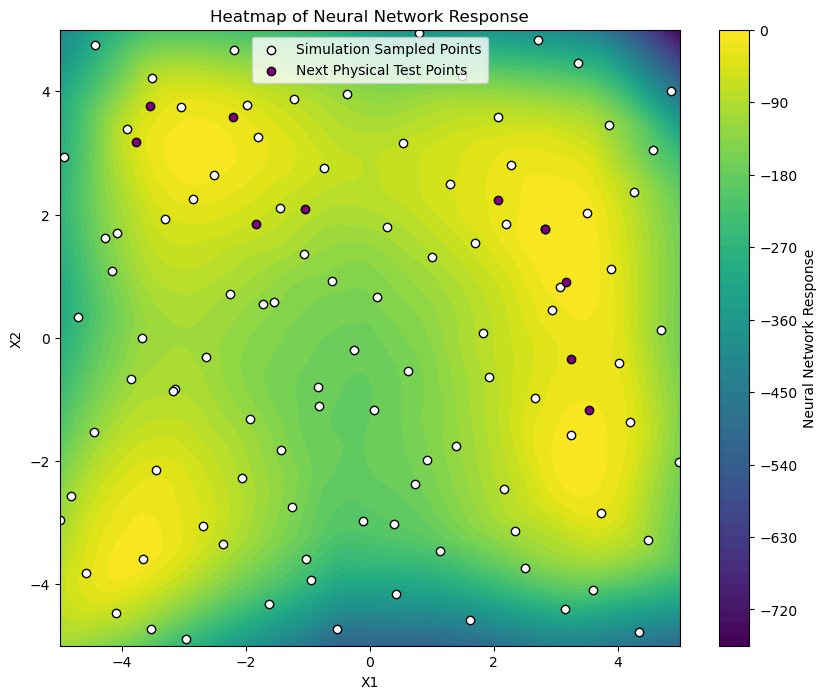

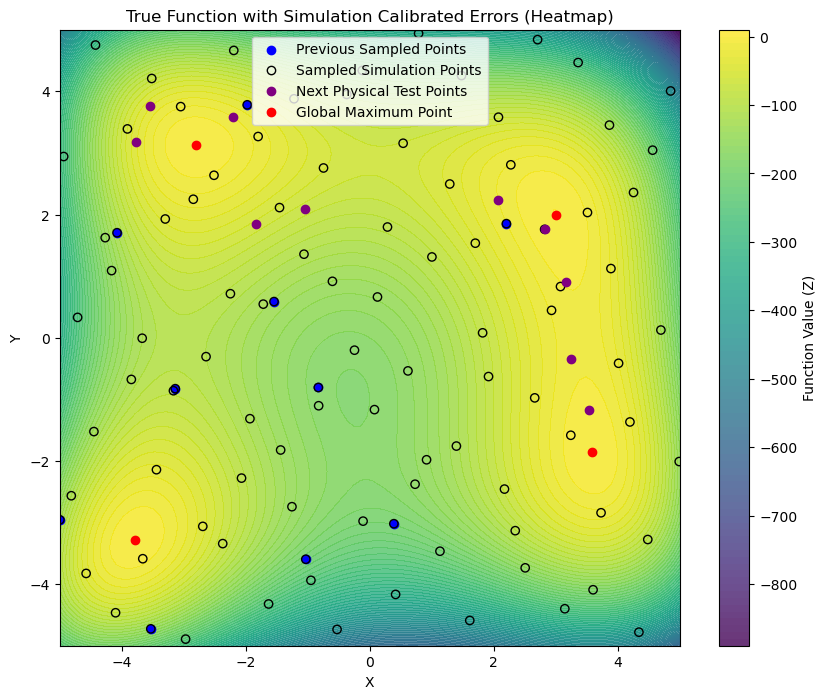

           x         y           z         a         b       sim_z      diff
0  -0.829780 -0.808055 -175.141124  4.046604 -3.225816 -175.129297 -0.011827
1   2.203245  1.852195  -20.326731  4.046604 -3.225816  -20.204231 -0.122500
2  -4.998856 -2.955478 -132.403402  4.046604 -3.225816 -132.080558 -0.322844
3  -1.976674  3.781174  -39.397506  4.046604 -3.225816  -39.709999  0.312493
4  -3.532441 -4.726124 -149.789289  4.046604 -3.225816 -149.717655 -0.071634
5  -4.076614  1.704675 -120.336105  4.046604 -3.225816 -120.650370  0.314265
6  -3.137398 -0.826952  -93.320859  4.046604 -3.225816  -93.237240 -0.083619
7  -1.544393  0.586898 -131.648403  4.046604 -3.225816 -131.711928  0.063525
8  -1.032325 -3.596131 -207.066951  4.046604 -3.225816 -207.154800  0.087849
9   0.388167 -3.018985 -198.619945  4.046604 -3.225816 -198.748059  0.128113
10  2.819990  1.759687   -2.785445  4.046604 -3.225816   -2.703376 -0.082069
11  3.531923 -1.177204   -4.390822  4.046604 -3.225816   -4.545699  0.154877

In [28]:
df = perform_iteration(df)
print(df)

[ 3.87732632 -3.07279547]


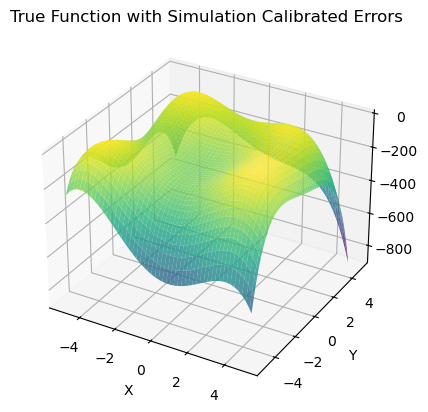

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 27418.4277
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26492.5156 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 26534.2246 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25320.4863 
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27030.3223 
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25230.3066 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21787.2793 
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20163.1426 
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15678.9941 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11941.0889 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13081.0820 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10129.0547 
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9810.0527  
Epoch 14/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10676.1562 
Epoch 15/500
2/2 ━━━━━━━━━━━━━

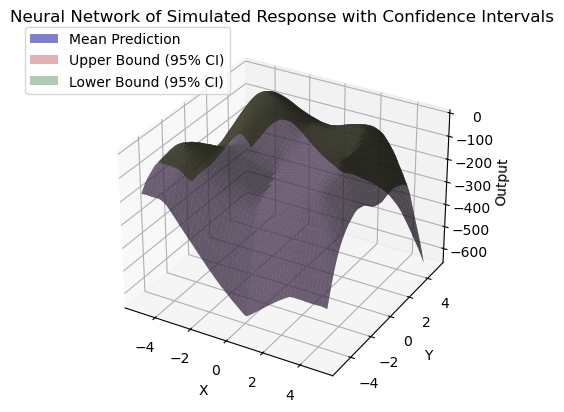

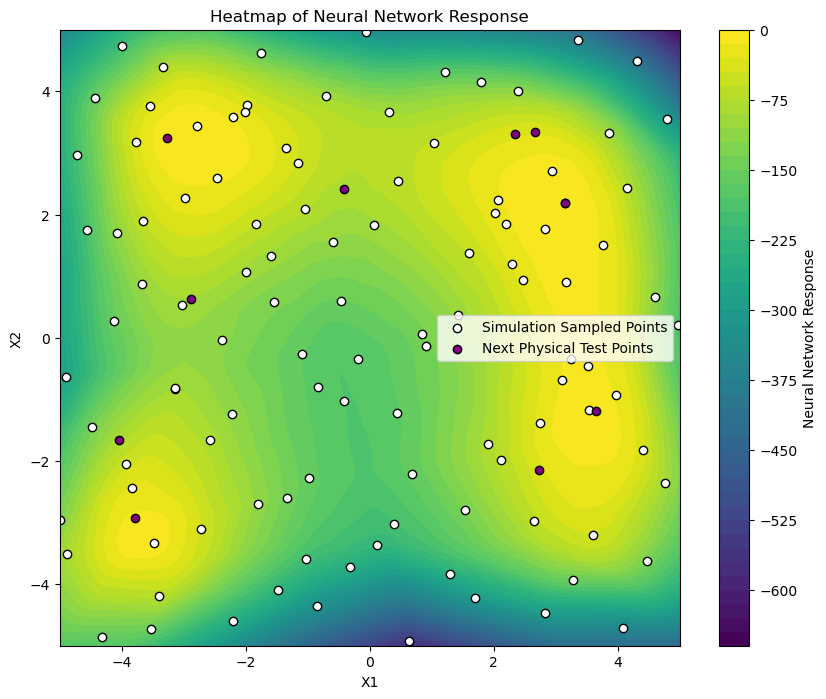

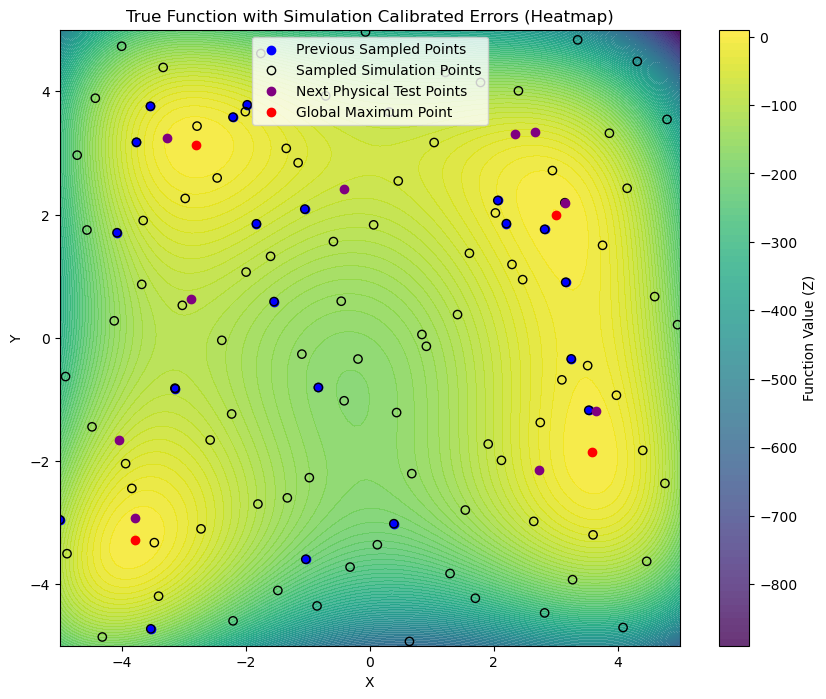

           x         y           z         a         b       sim_z      diff
0  -0.829780 -0.808055 -175.141124  3.877326 -3.072795 -175.084732 -0.056392
1   2.203245  1.852195  -20.326731  3.877326 -3.072795  -20.341697  0.014966
2  -4.998856 -2.955478 -132.403402  3.877326 -3.072795 -131.613696 -0.789705
3  -1.976674  3.781174  -39.397506  3.877326 -3.072795  -39.384105 -0.013401
4  -3.532441 -4.726124 -149.789289  3.877326 -3.072795 -149.161535 -0.627754
5  -4.076614  1.704675 -120.336105  3.877326 -3.072795 -120.335363 -0.000742
6  -3.137398 -0.826952  -93.320859  3.877326 -3.072795  -93.023172 -0.297687
7  -1.544393  0.586898 -131.648403  3.877326 -3.072795 -131.619472 -0.028931
8  -1.032325 -3.596131 -207.066951  3.877326 -3.072795 -206.917829 -0.149121
9   0.388167 -3.018985 -198.619945  3.877326 -3.072795 -198.670363  0.050417
10  2.819990  1.759687   -2.785445  3.877326 -3.072795   -2.889506  0.104060
11  3.531923 -1.177204   -4.390822  3.877326 -3.072795   -4.802084  0.411262

In [29]:
df = perform_iteration(df)
print(df)

[ 3.93939532 -3.07439129]


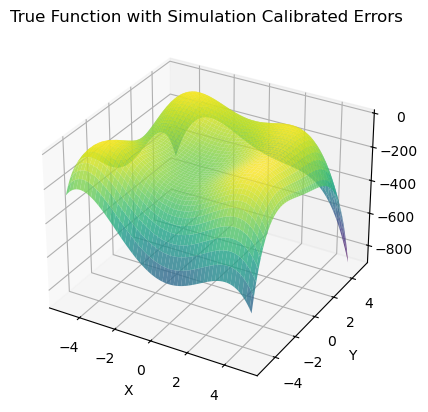

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 22665.1621
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25517.2227 
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25011.2871 
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25295.6348 
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26486.7012 
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23867.9219 
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20327.2754 
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16217.2529 
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12441.2119 
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12398.7100 
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11073.5205 
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9970.5361 
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9751.8486 
Epoch 14/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9988.1201 
Epoch 15/500
2/2 ━━━━━━━━━━━━━━━━

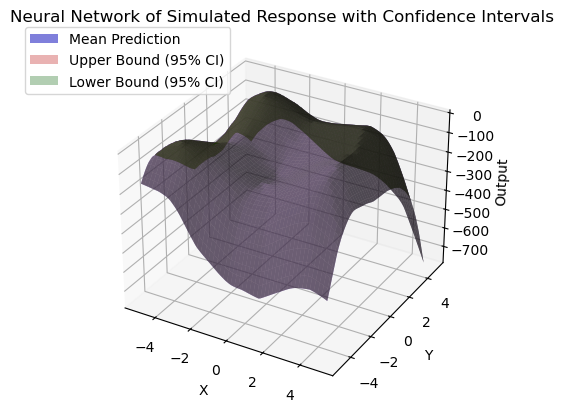

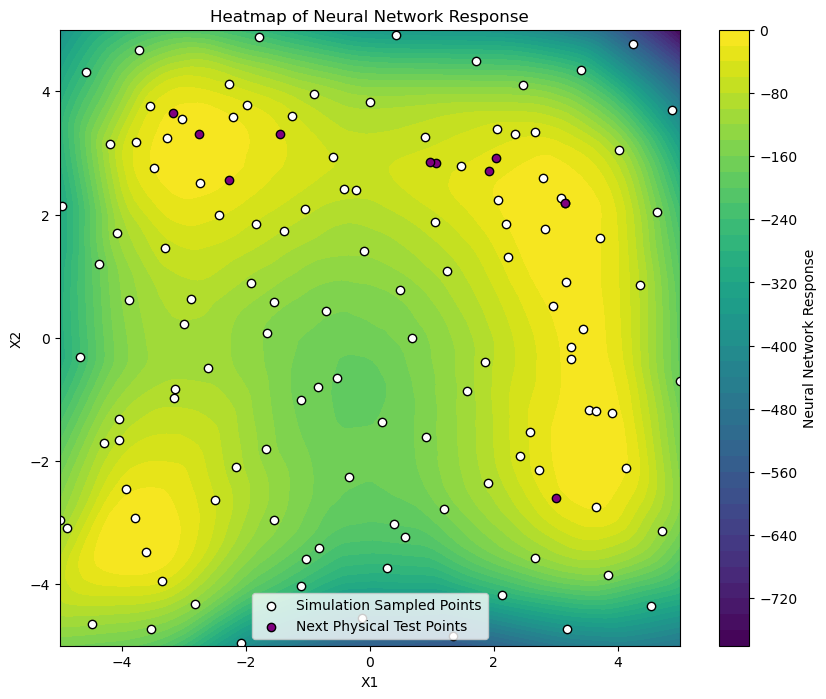

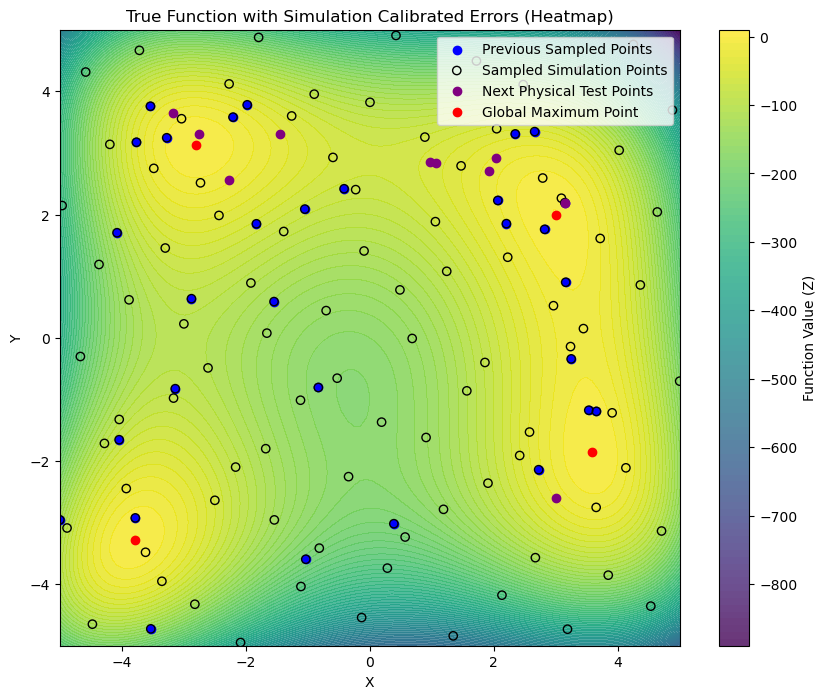

           x         y           z         a         b       sim_z      diff
0  -0.829780 -0.808055 -175.141124  3.939395 -3.074391 -175.116614 -0.024510
1   2.203245  1.852195  -20.326731  3.939395 -3.074391  -20.176124 -0.150607
2  -4.998856 -2.955478 -132.403402  3.939395 -3.074391 -131.849600 -0.553801
3  -1.976674  3.781174  -39.397506  3.939395 -3.074391  -39.407433  0.009927
4  -3.532441 -4.726124 -149.789289  3.939395 -3.074391 -149.232551 -0.556738
5  -4.076614  1.704675 -120.336105  3.939395 -3.074391 -120.549020  0.212916
6  -3.137398 -0.826952  -93.320859  3.939395 -3.074391  -93.193140 -0.127719
7  -1.544393  0.586898 -131.648403  3.939395 -3.074391 -131.695917  0.047514
8  -1.032325 -3.596131 -207.066951  3.939395 -3.074391 -206.892308 -0.174643
9   0.388167 -3.018985 -198.619945  3.939395 -3.074391 -198.581353 -0.038592
10  2.819990  1.759687   -2.785445  3.939395 -3.074391   -2.688872 -0.096573
11  3.531923 -1.177204   -4.390822  3.939395 -3.074391   -4.568483  0.177661

In [30]:
df = perform_iteration(df)
print(df)

[ 3.84774993 -2.98052051]


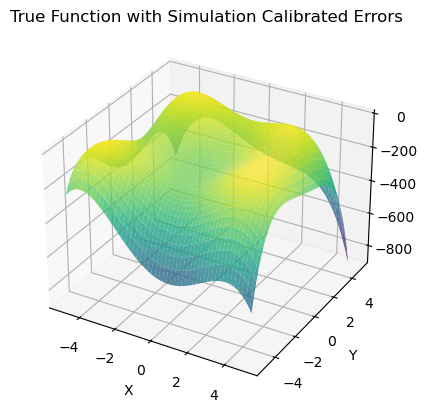

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 23211.8027
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23050.8398 
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22465.5195 
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21281.0352 
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17508.4199 
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11418.7324 
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10697.3096 
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15717.8809 
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9046.5322 
Epoch 10/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9724.3506  
Epoch 11/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10142.8477 
Epoch 12/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9377.2900  
Epoch 13/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8984.8574 
Epoch 14/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8977.8779 
Epoch 15/500
3/3 ━━━━━━━━━━━━━━━━

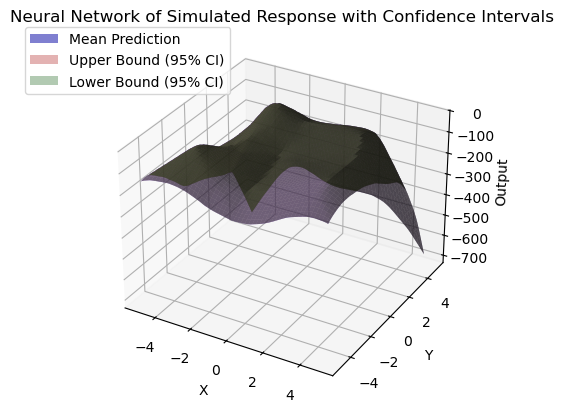

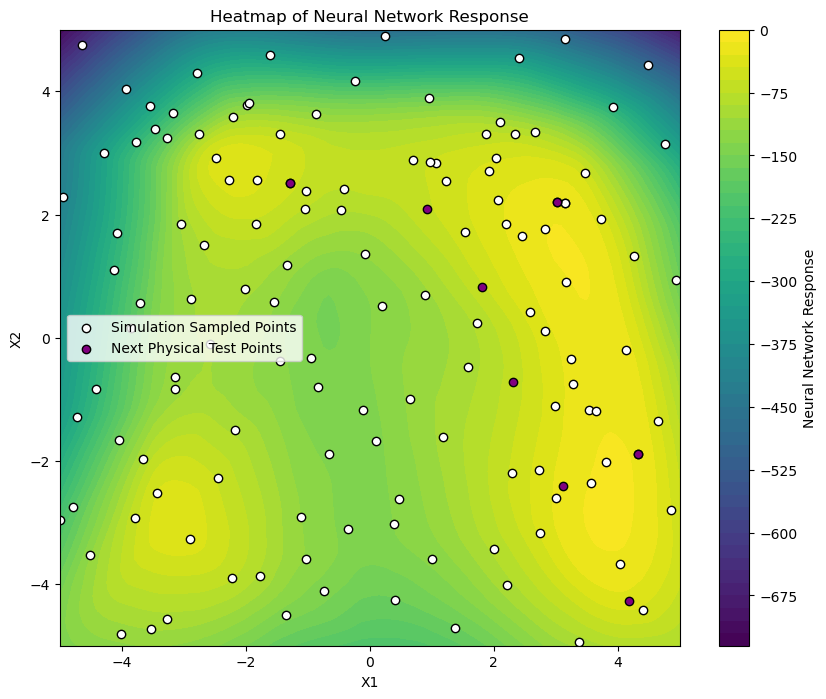

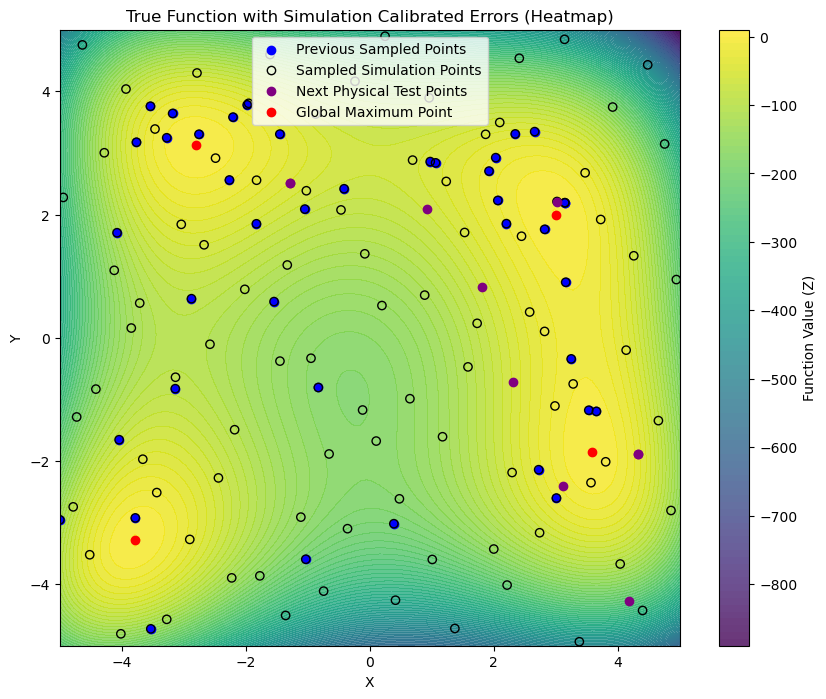

           x         y           z        a         b       sim_z      diff
0  -0.829780 -0.808055 -175.141124  3.84775 -2.980521 -175.092972 -0.048152
1   2.203245  1.852195  -20.326731  3.84775 -2.980521  -20.248114 -0.078617
2  -4.998856 -2.955478 -132.403402  3.84775 -2.980521 -131.707754 -0.695647
3  -1.976674  3.781174  -39.397506  3.84775 -2.980521  -39.363988 -0.033518
4  -3.532441 -4.726124 -149.789289  3.84775 -2.980521 -149.150589 -0.638700
5  -4.076614  1.704675 -120.336105  3.84775 -2.980521 -120.428824  0.092719
6  -3.137398 -0.826952  -93.320859  3.84775 -2.980521  -93.099126 -0.221733
7  -1.544393  0.586898 -131.648403  3.84775 -2.980521 -131.650128  0.001725
8  -1.032325 -3.596131 -207.066951  3.84775 -2.980521 -206.876156 -0.190795
9   0.388167 -3.018985 -198.619945  3.84775 -2.980521 -198.604291 -0.015654
10  2.819990  1.759687   -2.785445  3.84775 -2.980521   -2.779308 -0.006137
11  3.531923 -1.177204   -4.390822  3.84775 -2.980521   -4.678735  0.287914
12 -3.762927

In [31]:
df = perform_iteration(df)
print(df)